# Deep Learning Exercise
Below you'll find a data science exercise that may be solved with deep learning techniques.  While you're encouraged to use deep learning, this problem can certainly be solved other ways.  Be sure to document your thought processes and justify *why* you used your solution.

## Limits
You shouldn't spend longer than 1-2 hours on this exercise.  You won't be timed so be sure to relax and choose a time that suits you.  It's perfectly acceptable if you don't complete the exercise.  Just be sure to document your progress and explain your strategies.  You're encouraged to use and cite prior research.

## The Problem
The goal of this exercise is to build a reliable heartbeat detector given electrocardiogram (ECG) data.

## The Data
For this exercise we'll be using ECG data from the [MIT-BIH Arrhythmia Database](https://www.physionet.org/physiobank/database/mitdb/).  There's a handy tool [here](https://physionet.org/cgi-bin/atm/ATM) for converting this data to more usable formats.  The first data file, `100m.mat`, is already in the same directory as this notebook so you won't need to download anything unless you wish to collect more data.  If you do, use the [ATM](https://physionet.org/cgi-bin/atm/ATM) to export `.mat` files.  The annotations are obtained by selecting `Show annotations as text`.  Be sure to remove the `Aux` column if you import more annotations.

## Let's get started!

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

## Importing ECG data
We'll start by importing our ECG data.  There are two channels available and we'll be using the MLII channel.

In [16]:
signals = io.loadmat('100m.mat')
annotations = np.genfromtxt('annotations.txt',
                            dtype=[('time','|S9'),('sample','f'),('type','|S1')],
                            skip_header=1)

# The first channel contains MLII recordings
mlii_samples = signals['val'][0]

Let's check out what this data looks like.  Hopefully we'll see a heartbeat!

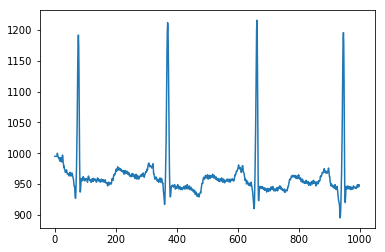

In [17]:
plt.plot(mlii_samples[:1000])

For training, we'll divide this data into a number of random 1000 sample long chunks.  We'll generate two sets of data: the raw samples and their spectral counterparts.

In [18]:
chunk_size = 1000
sample_size = 1000

# Generate random chunk indexes
sample_chunk_idx = np.random.randint(1, mlii_samples.size - chunk_size, sample_size)
sample_chunk_idx = np.array(np.rot90([sample_chunk_idx, sample_chunk_idx + chunk_size]))

sample_chunks = []
sample_chunks_f = []

# We'll use this hamming window for the STFT
stft_size = 32
hamming_window = signal.get_window('hamming', stft_size)

# Construct our main sample data set
for range in sample_chunk_idx:
  sample_chunks.append(mlii_samples[range[0]: range[1]])

# Things tend to work slightly better when rescaled to 0..1
scaler = MinMaxScaler(feature_range=(0, 1))
sample_chunks = scaler.fit_transform(sample_chunks)

# Compute the spectra for each chunk
for sample in sample_chunks:
  f, t, Zxx = signal.stft(sample, window = hamming_window, nperseg = stft_size)
  sample_chunks_f.append(np.abs(Zxx))

# Recast as a numpy array
sample_chunks_f = np.asarray(sample_chunks_f)

Our two sets of sample data now look like:

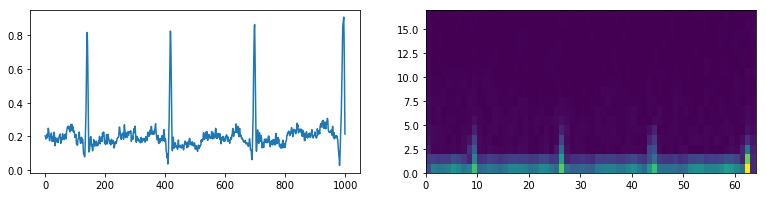

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(13, 3))
axs[0].plot(sample_chunks[0])
axs[1].pcolormesh(sample_chunks_f[0])

Now for our label data.  We'll construct a few label sets: indexes and one-hot encoded for both raw and spectra.

In [20]:
beats = annotations['sample']
sample_beats = []
sample_beats_oh = np.zeros((sample_size, chunk_size), dtype = int)
sample_beats_f_oh = np.zeros((sample_size, sample_chunks_f.shape[2]), dtype = int)

for i, chunk in enumerate(sample_chunk_idx):
    sample_beats.append(beats[np.where(np.logical_and(beats >= chunk[0], beats <= chunk[1]))])
    offset_beats = ((sample_beats[i] - sample_chunk_idx[i][0]) - 1).astype(int)
    sample_beats_oh[i, offset_beats] = 1
    sample_beats_f_oh[i, (offset_beats / stft_size * 2).astype(int)] = 1

# Recast as numpy array
sample_beats = np.asarray(sample_beats)

Let's plot our sample data together with our label data to ensure they line up:

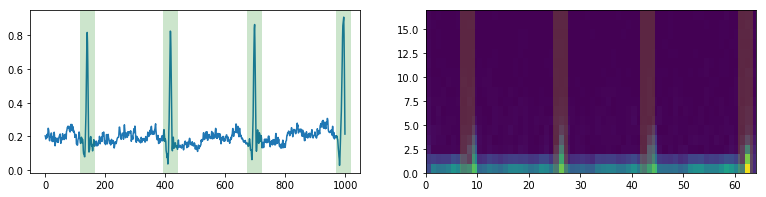

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(13, 3))
axs[0].plot(sample_chunks[0])
for xc in np.where(sample_beats_oh[0] == 1)[0]:
    axs[0].axvline(x = xc, linewidth=15, color='g', alpha=0.2)
    
axs[1].pcolormesh(sample_chunks_f[0])
for xc in np.where(sample_beats_f_oh[0] == 1)[0]:
    axs[1].axvline(x = xc, linewidth=15, color='y', alpha=0.2) 

Now it's your turn!  Using any or all of the data sets provided, build a deep learning model that predicts the location of heartbeats given a sample of ECG data.

To summarize your available data:

    sample_chunks: raw samples
    sample_beats: beat index locations (0-indexed)
    sample_beats_oh: one-hot encoded beat locations
    sample_chunks_f: spectra of samples
    sample_beats_f_oh: beat index locations for spectra

## I'll start here!

This looks like a classification problem. We have heartbeats (category 1) and "not-hearbeats" (0). We need to develop a model that can 1000-sample chunk of data and output an approximate location of a heartbeat.

A few quick notes: I prefer python3, so I have solved this challenge in Python3. I've done my best to be python2 friendly in all my code, in case anyone else needs to run it, but let me know if there's any issues!

My initial thoughts revolved around avoiding machine learning in favor of using calculus to find points of local extrema, but the noise (mains ripple, breathing, skeletal muscles) varies too much for that to be a good solution. I could procedurally set the values, but I'd need more data to generalize from for that to be a good solution. During my whiteboarding, I kept coming back to a need to identify sudden spikes while ignoring background noise, when I remembered that's what neurons are excel at. 

I'll be using the MLPClassifier module, because it seems to be the easiset estimator to work with, the most vanilla type of neural network, as someone more familiar with the concept of machine learning than the specifics of sklearn.

I'll put my predictions in a one-hot encoded array similar to sample_beats_oh called my_beats_oh

In [26]:
from sklearn.neural_network import MLPClassifier

#checking that the dimensions are compatible, to see if 
#I can use the sample_beats as a training data set
print(sample_chunks.shape)
print(sample_beats_oh.shape)

X = sample_chunks
Y = sample_beats_oh
#I've tweaked the hidden layer sizes a few times until I started getting results.
#The first shape to predict a beat was (1000, 1000,300), and the output is below
clf = MLPClassifier(hidden_layer_sizes=(1000,1000,300),learning_rate='adaptive',tol = 1e-3,)
clf.fit(X,Y)
print(clf.get_params())
print("Score:", clf.score(X,Y))
my_beats_oh = clf.predict(sample_chunks[0])
beatsfound = my_beats_oh.sum() 
beatsexpected = sample_beats_oh[0].sum()
print("The model found", beatsfound,"heartbeats, but we expected",beatsexpected)




(1000, 1000)
(1000, 1000)
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (1000, 1000, 300), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Score: 0.02
The model found 1 heartbeats, but we expected 4


C:\Users\james\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\james\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


I'm not particularly familiar with sklearn as a framework for machine learning, but it seems that it should just be a matter of finetuning the structure of the layers now.

Let's see how I did. I got one prediction after a few attempts. Is it accurate?

Mine's on the left


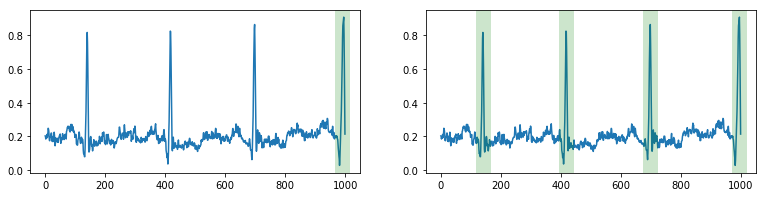

In [54]:
print("Mine's on the left")
fig, axs = plt.subplots(1, 2, figsize=(13, 3))
axs[0].plot(sample_chunks[0])
for xc in np.where(my_beats_oh[0] == 1)[0]:
    axs[0].axvline(x = xc, linewidth=15, color='g', alpha=0.2)
axs[1].plot(sample_chunks[0])
for xc in np.where(sample_beats_oh[0] == 1)[0]:
    axs[1].axvline(x = xc, linewidth=15, color='g', alpha=0.2)

Looks pretty close!
I'll run a few more trials:

In [63]:
X = sample_chunks
Y = sample_beats_oh
#I've tweaked the hidden layer sizes a few times until I started getting results.
#The first shape to successfully predict a beat was (1000, 1000,300)
clf = MLPClassifier(hidden_layer_sizes=(1000,1000,1000))
clf.fit(X,Y)
print(clf.get_params())
print("Score:", clf.score(X,Y))
my_beats_oh = clf.predict(sample_chunks)
beatsfound = my_beats_oh.sum() 
beatsexpected = sample_beats_oh.sum()
print("The model found", beatsfound,"heartbeats, but we expected",beatsexpected)



C:\Users\james\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (1000, 1000, 1000), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Score: 0.192
The model found 2217 heartbeats, but we expected 3522


This is starting to get computationally expensive, and that's eating up most of the time I would spend on this. I now know that 3 hidden layers can detect heartbeats some of the time, and increasing number of nodes seems to help, so I know that I could programmatically search out a more correct neural network architecture. I would continue this by running trials in parallel, and ideally switch to a framework support GPU acceleration like Tensorflow. 

I could improve the output by using some post-processing as well. For instance, I could check the output of the model by using some calculus. For instance, we could use numpy's diff function to identify the 2 inflection points nearest a potential heartbeat, and if those points are close enough to the peak on the ecg, and the slopes steep enough, than it is likely a correct identification. Conversely, if the heartbeat is not detected close enough to a local maxima found by taking the second derivative of our ecg output, we know it may be a false positive.

I think the ideal solution here uses a mix of machine learning and calculs. The advantage of machine learning here is that it allows us to generalize to more data than this one case, without writing new code, just by training on new datasets. The calculus allows us to make a priori assumptions about the data that hold true regardless of the individual parameters of the data, simply because of the shape we know it would have. 

The most complete solution would implement all these tehcniques on the fourier transformed data as well, since that can discriminate noise with different frequencies, whether we errantly detect skeletal muscle impulses or breathing. There are numerous tools that can be used to improve the output, but ultimately more experimentation is needed to further optimize the results.

Citations:
https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
This video helped me figure out the basic syntax:
https://www.youtube.com/watch?v=IsXXlYVBt1M&index=2&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A